<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/Image_Segmentation_using_tf_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Cityscapes Image Segmentation**

In [1]:
#https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/cityscapes-image-pairs.zip

In [4]:
import numpy as np
import tensorflow as tf
import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
x = []
y = []

image_dir = "/content/cityscapes_data/cityscapes_data/train"
image_paths = os.listdir(image_dir)
for path in image_paths[0:400]:
    image = Image.open(os.path.join(image_dir, path))
    x.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0)).resize((128, 128))))
    y.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0)).resize((128, 128))))

x = np.array(x) / 255.0
y = np.array(y)

train_features, test_features, train_labels, test_labels = train_test_split(np.array(x), np.array(y),
                                                                                    test_size=0.4)

def binarize(pixel):
    if np.array_equal(pixel, [128, 63, 127]):
        return np.array([1])
    else :
        return np.array([0])

train_labels = np.apply_along_axis(binarize , axis = 3 , arr = train_labels)
test_labels = np.apply_along_axis(binarize , axis = 3 , arr = test_labels)

batch_size = 5

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.shuffle(1024).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
valid_dataset = valid_dataset.shuffle(1024).batch(batch_size)

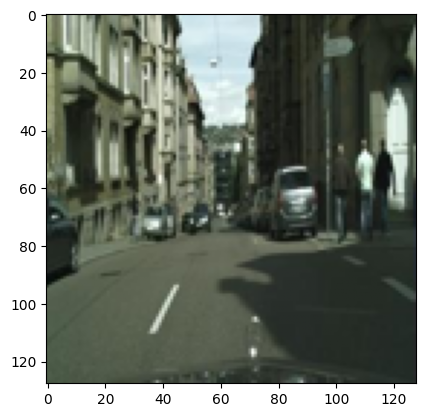

In [6]:
plt.imshow(x[0])

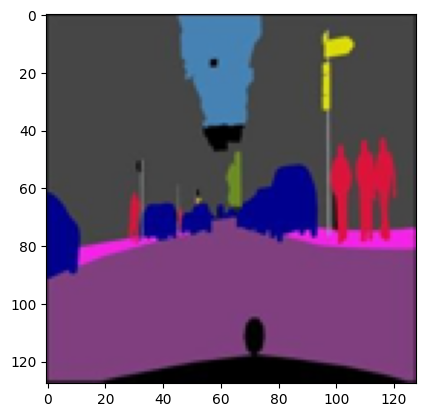

In [7]:
plt.imshow(y[0])

In [13]:
alpha = 0.2
padding = "SAME"

def conv2d_down(inputs, filters, strides):
    out = tf.nn.conv2d(inputs, filters, strides = strides, padding = padding )
    return tf.nn.leaky_relu(out, alpha = alpha)

def maxpool_down(inputs, pool_size, strides):

    return tf.nn.max_pool(inputs, ksize = pool_size, padding = 'VALID', strides = strides)

def conv2d_up(inputs, filters, strides, output_shape):
    out = tf.nn.conv2d_transpose(inputs, filters, output_shape = output_shape, strides = strides, padding = padding)
    return tf.nn.leaky_relu(out, alpha = alpha)

def maxpool_up(inputs, size):
    in_dimen = tf.shape(inputs)[1]
    out_dimen = tf.cast(tf.round(in_dimen * size) , dtype=tf.int32)
    return tf.image.resize(inputs, [out_dimen, out_dimen], method = 'nearest')

In [14]:
initializer = tf.initializers.glorot_uniform()
def get_weight(shape, name):
    return tf.Variable(initializer(shape) , name = name , trainable = True)

shapes = [
    [ 3 , 3 , 3 , 16 ] , # conv2d [filter_height, filter_width, in_channels, out_channels]
    [ 3 , 3 , 16 , 16 ] ,

    [ 3 , 3 , 16 , 32 ] ,
    [ 3 , 3 , 32 , 32 ] ,

    [ 3 , 3 , 32 , 64 ] ,
    [ 3 , 3 , 64 , 64 ] ,

    [ 3 , 3 , 64 , 128 ] ,
    [ 3 , 3 , 128 , 128 ] ,

    [ 3 , 3 , 128 , 256 ] ,
    [ 3 , 3 , 256 , 256 ] ,

    [ 3 , 3 , 128 , 384 ], # conv2d transpose [height,width, output_channels, in_channels]
    [ 3 , 3 , 128 , 128 ],

    [ 3 , 3 , 64 , 192 ],
    [ 3 , 3 , 64 , 64 ],

    [ 3 , 3 , 32 , 96 ],
    [ 3 , 3 , 32 , 32 ],

    [ 3 , 3 , 16 , 48 ],
    [ 3 , 3 , 16 , 16 ],

    [ 1 , 1 , 16 , 1 ],
]

weights = []
for i in range(len(shapes)):
    weights.append(get_weight(shapes[ i ] , 'weight{}'.format(i)))

In [15]:
def model(inputs) :
    batch_size = tf.shape(inputs)[0]
    x = tf.cast(inputs, dtype = tf.float32)
    c1 = conv2d_down(x, weights[0], strides = 1)
    c1 = conv2d_down(c1, weights[1], strides = 1)
    p1 = maxpool_down(c1, pool_size = 2, strides = 2)

    c2 = conv2d_down(p1, weights[2], strides = 1)
    c2 = conv2d_down(c2, weights[3], strides = 1)
    p2 = maxpool_down(c2 , pool_size = 2 , strides = 2)

    c3 = conv2d_down(p2, weights[4], strides = 1 )
    c3 = conv2d_down(c3, weights[5], strides = 1 )
    p3 = maxpool_down(c3, pool_size = 2, strides = 2 )

    c4 = conv2d_down(p3, weights[6], strides = 1)
    c4 = conv2d_down(c4, weights[7], strides = 1)
    p4 = maxpool_down(c4, pool_size = 2, strides = 2)

    c5 = conv2d_down(p4, weights[8], strides = 1)
    c5 = conv2d_down(c5, weights[9], strides = 1)

    p5 = maxpool_up(c5, 2)
    concat_1 = tf.concat([p5, c4], axis = -1)
    c6 = conv2d_up(concat_1, weights[10], strides = 1, output_shape = [batch_size, 16, 16, 128])
    c6 = conv2d_up(c6, weights[11], strides = 1, output_shape = [batch_size, 16, 16, 128])

    p6 = maxpool_up(c6, 2)
    concat_2 = tf.concat([p6, c3] , axis = -1)
    c7 = conv2d_up(concat_2, weights[12], strides = 1, output_shape = [batch_size, 32, 32, 64])
    c7 = conv2d_up(c7, weights[13], strides = 1, output_shape = [batch_size, 32, 32, 64])

    p7 = maxpool_up(c7, 2)
    concat_3 = tf.concat([p7, c2], axis = -1)
    c8 = conv2d_up(concat_3, weights[14], strides = 1, output_shape = [batch_size, 64, 64, 32])
    c8 = conv2d_up(c8, weights[15], strides = 1, output_shape = [batch_size, 64, 64, 32])

    p8 = maxpool_up(c8, 2)
    concat_4 = tf.concat([p8, c1] , axis = -1)
    c9 = conv2d_up(concat_4, weights[16], strides = 1, output_shape = [batch_size, 128, 128, 16])
    c9 = conv2d_up(c9, weights[17], strides = 1, output_shape = [batch_size, 128, 128, 16])

    output = tf.nn.conv2d(c9, weights[18], strides = [1, 1, 1, 1], padding = padding)
    outputs = tf.nn.sigmoid(output)
    return outputs

In [16]:
def loss(pred, target):
    return tf.losses.binary_crossentropy(target, pred)

#@markdown > The learning rate used during optimization using Adam.
learning_rate = "0.001"  #@param ["0.1" , "0.001" , "0.0001" , "0.05"]
optimizer = tf.optimizers.Adam(learning_rate = float(learning_rate))

def train(model, inputs, outputs):
    with tf.GradientTape() as tape:
        current_loss = loss(model(inputs), outputs)
    grads = tape.gradient(current_loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    return tf.reduce_mean(current_loss)

In [17]:
import datetime

logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

#@markdown > Number of epochs for training the model
num_epochs = 25  #@param {type: "number"}

for epoch in range( num_epochs ):
    print( 'Epoch {} out of {} {}'.format(epoch + 1, num_epochs, '--' * 50))
    for features in train_dataset:
        image , label = features
        summ_loss = train(model, image, label)
        tf.summary.scalar('loss', data = summ_loss, step = epoch)

Epoch 1 out of 25 ----------------------------------------------------------------------------------------------------


Epoch 2 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 3 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 4 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 5 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 6 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 7 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 8 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 9 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 10 out of 25 -----------------------------

In [ ]:
tf.saved_model.save(model , "module_no_signatures")

In [ ]:
input_image = test_features[0:30]
pred = model(input_image).numpy()
image = np.zeros((128, 128, 3))
for x in range(128):
    for y in range(128 ):
        if pred[0, x, y] > 0.5:
            image[x, y] = [255, 255, 255]
        else:
            image[x, y] = [0, 0, 0]

def show_images(images: list):
    n = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation = 'none')
    plt.show()

show_images([test_features[6] , image])